In [4]:
import yfinance as yf
import pandas as pd
from pandas_datareader import data as web
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

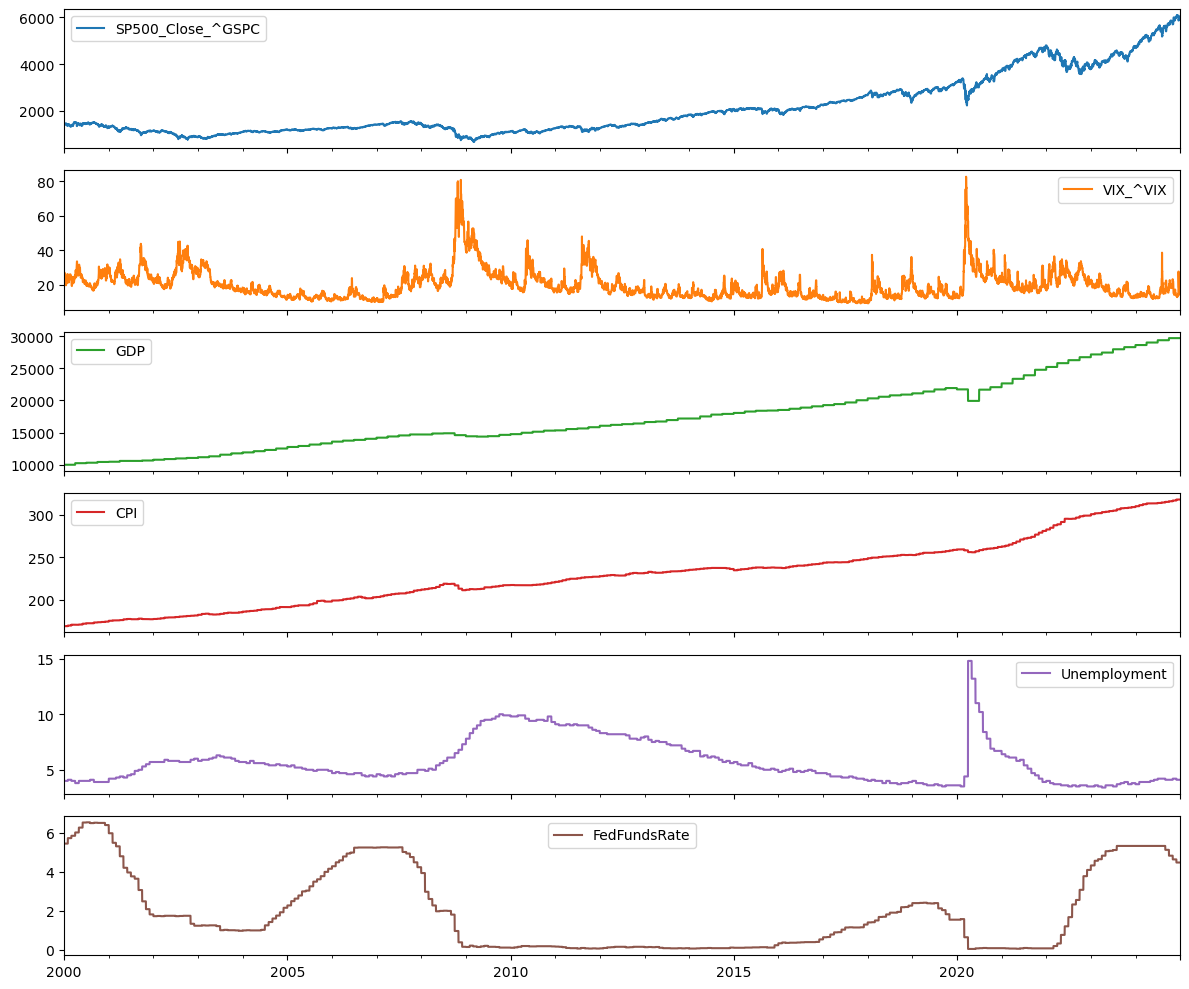

In [5]:
# Define the date range for historical data
start_date = '2000-01-01'
end_date = '2024-12-31'

# Download S&P 500 closing prices and rename column for clarity
sp500 = yf.download('^GSPC', start=start_date, end=end_date, progress=False)[['Close']].rename(columns={'Close': 'SP500_Close'})

# Download VIX (Volatility Index) closing prices and rename column
vix = yf.download('^VIX', start=start_date, end=end_date, progress=False)[['Close']].rename(columns={'Close': 'VIX'})

# Define economic indicators to fetch from the Federal Reserve Economic Data (FRED)
fred_series = {
    'GDP': 'GDP',  # Gross Domestic Product
    'CPI': 'CPIAUCSL',  # Consumer Price Index (inflation measure)
    'Unemployment': 'UNRATE',  # Unemployment rate
    'FedFundsRate': 'FEDFUNDS'  # Federal Funds Rate
}

# Download macroeconomic data from FRED
macro_data = {key: web.DataReader(series, 'fred', start_date, end_date) for key, series in fred_series.items()}

# Combine all macroeconomic data into a single DataFrame
macro_df = pd.concat(macro_data.values(), axis=1)
macro_df.columns = macro_data.keys()  # Rename columns to their respective indicator names

# Resample macroeconomic data to daily frequency, forward-filling missing values
macro_df = macro_df.resample('D').ffill()

# Ensure macro data aligns with stock market data (S&P 500 and VIX)
macro_df = macro_df.reindex(pd.date_range(start=macro_df.index.min(), end=sp500.index.max(), freq='D')).ffill()

# Ensure all DataFrame indices are in datetime format
sp500.index = pd.to_datetime(sp500.index)
vix.index = pd.to_datetime(vix.index)
macro_df.index = pd.to_datetime(macro_df.index)

# Merge S&P 500 and VIX data using an outer join to include all dates
temp_merge = sp500.merge(vix, left_index=True, right_index=True, how='outer')

# Rename columns to avoid potential naming conflicts
temp_merge.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in temp_merge.columns]

# Merge with macroeconomic data to create the final dataset
final_merge = temp_merge.merge(macro_df, left_index=True, right_index=True, how='outer')

# Fill forward (ffill) and backward (bfill) any remaining missing values
final_merge.ffill(inplace=True)
final_merge.bfill(inplace=True)

# Check for missing dates in the final dataset
date_range = pd.date_range(start=final_merge.index.min(), end=final_merge.index.max(), freq='D')
missing_dates = date_range.difference(final_merge.index)

# Generate summary statistics of the final dataset
summary_stats = final_merge.describe()

# Plot the time series of S&P 500, VIX, and macroeconomic indicators
final_merge[['SP500_Close_^GSPC', 'VIX_^VIX', 'GDP', 'CPI', 'Unemployment', 'FedFundsRate']].plot(subplots=True, figsize=(12, 10))

# Adjust layout and display the plot
plt.tight_layout()
plt.show()


In [6]:
# Compute Exponential Moving Averages (EMAs) for S&P 500 and macroeconomic indicators
final_merge['SP500_EMA_7'] = final_merge['SP500_Close_^GSPC'].ewm(span=7, adjust=False).mean()  # 7-day EMA for S&P 500
final_merge['SP500_EMA_30'] = final_merge['SP500_Close_^GSPC'].ewm(span=30, adjust=False).mean()  # 30-day EMA for S&P 500
final_merge['GDP_EMA_30'] = final_merge['GDP'].ewm(span=30, adjust=False).mean()  # 30-day EMA for GDP
final_merge['CPI_EMA_30'] = final_merge['CPI'].ewm(span=30, adjust=False).mean()  # 30-day EMA for CPI
final_merge['Unemployment_EMA_30'] = final_merge['Unemployment'].ewm(span=30, adjust=False).mean()  # 30-day EMA for Unemployment
final_merge['FedFundsRate_EMA_30'] = final_merge['FedFundsRate'].ewm(span=30, adjust=False).mean()  # 30-day EMA for Fed Funds Rate

# Compute daily return of the S&P 500
final_merge['SP500_Return'] = final_merge['SP500_Close_^GSPC'].pct_change()

# Create a lagged version of the VIX index (previous day's value)
final_merge['VIX_Lag_1'] = final_merge['VIX_^VIX'].shift(1)

# Define a binary target variable:
# If the short-term EMA (7-day) is greater than the long-term EMA (30-day), set to 1 (uptrend), else 0 (downtrend)
final_merge['Target'] = (final_merge['SP500_EMA_7'] > final_merge['SP500_EMA_30']).astype(int)

# Drop rows with NaN values after calculations
final_merge.dropna(inplace=True)

# Define feature set for modeling
features = [
    'SP500_EMA_30', 'VIX_^VIX', 'SP500_EMA_7',  # S&P 500 technical indicators
    'GDP_EMA_30', 'CPI_EMA_30', 'Unemployment', 'FedFundsRate',  # Macroeconomic indicators
    'VIX_Lag_1'  # Lagged VIX for volatility tracking
]

# Define target variable
target = 'Target'

In [7]:
# Scale the data set

scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(final_merge[features]), columns=features, index=final_merge.index)
y = final_merge[target]

split_index = int(len(X) * 0.8)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

In [8]:
#Fit the logistic model

model = LogisticRegression(class_weight='balanced')
model.fit(X_train, y_train)

predictions = model.predict(X_test)

accuracy = accuracy_score(y_test, predictions)
conf_matrix = confusion_matrix(y_test, predictions)
report = classification_report(y_test, predictions)

# Results

print(accuracy)
print(conf_matrix)
print(report)


0.8581599123767798
[[ 372  190]
 [  69 1195]]
              precision    recall  f1-score   support

           0       0.84      0.66      0.74       562
           1       0.86      0.95      0.90      1264

    accuracy                           0.86      1826
   macro avg       0.85      0.80      0.82      1826
weighted avg       0.86      0.86      0.85      1826



In [9]:
# Fit an alternative model, a linear SVM

svm_model = SVC(kernel='linear', random_state=42)
svm_model.fit(X_train, y_train)

y_pred_svm = svm_model.predict(X_test)

accuracy_rf = accuracy_score(y_test, y_pred_svm)
accuracy = accuracy_score(y_test, y_pred_svm)
conf_matrix = confusion_matrix(y_test, y_pred_svm)
report = classification_report(y_test, y_pred_svm)

# Results

print(accuracy)
print(conf_matrix)
print(report)

0.932092004381161
[[ 500   62]
 [  62 1202]]
              precision    recall  f1-score   support

           0       0.89      0.89      0.89       562
           1       0.95      0.95      0.95      1264

    accuracy                           0.93      1826
   macro avg       0.92      0.92      0.92      1826
weighted avg       0.93      0.93      0.93      1826

